In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [123]:

import sys
import os

#Graph imports
sys.path.append('../..')
import src.logit_graph.graph as graph
import src.logit_graph.logit_estimator as estimator
import src.logit_graph.utils as utils
import src.logit_graph.model_selection as model_selection
import src.logit_graph.gic as gic
import src.logit_graph.param_estimator as pe
import src.logit_graph.graph as graph
import src.logit_graph.model_selection as ms

from src.logit_graph.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [5]:
data_directory = f'../../data/connectomes/'
os.listdir(data_directory)

['p.pacificus_neural.synaptic_2.graphml',
 'rhesus_cerebral.cortex_1.graphml',
 'rattus.norvegicus_brain_1.graphml',
 'mixed.species_brain_1.graphml',
 'mouse_visual.cortex_2.graphml',
 '.DS_Store',
 'rattus.norvegicus_brain_2.graphml',
 'p.pacificus_neural.synaptic_1.graphml',
 'mouse_visual.cortex_1.graphml',
 'rattus.norvegicus_brain_3.graphml',
 'rhesus_interareal.cortical.network_2.graphml',
 'rhesus_brain_1.graphml',
 'mouse_retina_1.graphml',
 'kasthuri_graph_v4.graphml',
 'mouse_brain_1.graphml',
 'drosophila_medulla_1.graphml',
 'c.elegans.herm_pharynx_1.graphml',
 'rhesus_brain_2.graphml',
 'c.elegans_neural.male_1.graphml']

### Comparison other models

comparing multiple models excluding the simulation of LG because it was alaready simulated

In [7]:
graph_files = [f for f in os.listdir(data_directory) if f.endswith('.graphml')]
graph_files = [os.path.join(data_directory, f) for f in graph_files]

graph_files_with_sizes = []
for graph_file in graph_files:
    try:
        g = nx.read_graphml(graph_file)
        graph_files_with_sizes.append((graph_file, g.number_of_nodes()))
    except:
        graph_files_with_sizes.append((graph_file, 0))

graph_files_with_sizes.sort(key=lambda x: x[1])
graph_files = [f for f, _ in graph_files_with_sizes]
graph_files

['../../data/connectomes/mouse_visual.cortex_1.graphml',
 '../../data/connectomes/p.pacificus_neural.synaptic_2.graphml',
 '../../data/connectomes/p.pacificus_neural.synaptic_1.graphml',
 '../../data/connectomes/mixed.species_brain_1.graphml',
 '../../data/connectomes/rhesus_cerebral.cortex_1.graphml',
 '../../data/connectomes/rhesus_brain_2.graphml',
 '../../data/connectomes/rhesus_interareal.cortical.network_2.graphml',
 '../../data/connectomes/mouse_visual.cortex_2.graphml',
 '../../data/connectomes/mouse_brain_1.graphml',
 '../../data/connectomes/rhesus_brain_1.graphml',
 '../../data/connectomes/c.elegans_neural.male_1.graphml',
 '../../data/connectomes/c.elegans.herm_pharynx_1.graphml',
 '../../data/connectomes/rattus.norvegicus_brain_3.graphml',
 '../../data/connectomes/rattus.norvegicus_brain_1.graphml',
 '../../data/connectomes/rattus.norvegicus_brain_2.graphml',
 '../../data/connectomes/kasthuri_graph_v4.graphml',
 '../../data/connectomes/mouse_retina_1.graphml',
 '../../data/

In [10]:
graph_files = ['../../data/connectomes/rhesus_cerebral.cortex_1.graphml']

In [82]:
import os
import math
import networkx as nx
import numpy as np

# --- Provided Setup ---
comparators = {}
folder_name = 'runs/fitted_graphs_comparison_connectomes_simple_1'
os.makedirs(folder_name, exist_ok=True)

# --- Barabasi-Albert (BA) Model Functions (Provided) ---
def _expected_ba_edges(n, m):
    # networkx.barabasi_albert_graph starts with a complete graph of m nodes,
    # then adds (n - m) nodes, each with m edges
    return m * (n - m) + (m * (m - 1)) // 2

def estimate_ba_m(n, e):
    # Solve: m^2 - (2n - 1)m + 2e = 0
    D = (2 * n - 1) ** 2 - 8 * e
    candidates = []
    if D >= 0:
        m_real = ((2 * n - 1) - math.sqrt(D)) / 2.0
        candidates.extend([math.floor(m_real), math.ceil(m_real)])
    # heuristic fallback
    candidates.append(round(e / n if n > 0 else 1))
    # expand neighborhood and clamp
    uniq = set(int(m) for m in candidates)
    expanded = set()
    for m in uniq:
        for dm in (-1, 0, 1):
            expanded.add(m + dm)
    valid = [m for m in expanded if 1 <= m < n]
    if not valid:
        return 1
    # pick m minimizing edge discrepancy
    best_m = min(valid, key=lambda m: abs(_expected_ba_edges(n, m) - e))
    return best_m

# --- Erdős-Rényi (ER) Model Estimation ---

def estimate_er_p(n, e):
    """Estimates the optimal edge probability 'p' for an Erdős-Rényi graph."""
    if n < 2:
        return 0.0
    # Expected edges E = p * C(n, 2) => p = E / C(n, 2)
    p = (2 * e) / (n * (n - 1))
    # Clamp p to the valid probability range [0, 1]
    return max(0.0, min(1.0, p))

# --- Watts-Strogatz (WS) Model Estimation ---

def estimate_ws_params(n, e):
    """
    Estimates optimal parameters 'k' and 'p' for a Watts-Strogatz graph.
    'k' is chosen to best match the edge count. 'p' is set to a default value.
    """
    # WS graph requires n > k, and k must be an even integer >= 2.
    if n <= 2:
        return 0, 0.1

    # The number of edges in a WS graph is exactly n*k/2.
    # We find the even integer 'k' that makes n*k/2 closest to e.
    k_target = 2 * e / n
    
    # Check the two nearest even integers to the target average degree.
    k_floor = int(k_target // 2 * 2)
    k_ceil = int(k_target // 2 * 2 + 2)

    candidates = [k for k in [k_floor, k_ceil] if 2 <= k < n]

    if not candidates:
        # Fallback if no valid k can be found (e.g., n is too small).
        return (2, 0.1) if n > 2 else (0, 0.1)

    # Pick the candidate 'k' that minimizes the edge discrepancy.
    best_k = min(candidates, key=lambda k: abs(n * k / 2 - e))

    # The rewiring probability 'p' cannot be determined from n and e alone.
    # A common default value for generating small-world networks is used.
    p = 0.1
    
    return best_k, p

# --- Geometric Random Graph (GRG) Model Estimation ---

def estimate_grg_radius(n, e):
    """
    Estimates the optimal radius 'r' for a Geometric Random Graph.
    Nodes are placed uniformly at random in a unit square [0,1] x [0,1].
    Two nodes are connected if their Euclidean distance is at most r.
    """
    if n < 2:
        return 0.0
    
    # Expected number of edges in a GRG is approximately:
    # E[edges] ≈ n * (n-1) * π * r^2 / 2
    # Solving for r: r ≈ sqrt(2*e / (n*(n-1)*π))
    
    if e == 0:
        return 0.0
    
    r_estimate = math.sqrt(2 * e / (n * (n - 1) * math.pi))
    
    # Clamp radius to reasonable bounds (can't exceed sqrt(2) for unit square diagonal)
    return max(0.0, min(r_estimate, math.sqrt(2)))

# --- Main Loop for Graph Generation and Comparison ---

for graph_file in graph_files:
    # Read as graphml instead of edgelist
    original_graph = nx.read_graphml(graph_file)
    # Convert to undirected and relabel nodes to integers
    original_graph = nx.convert_node_labels_to_integers(original_graph.to_undirected())
    
    n = original_graph.number_of_nodes()
    e = original_graph.number_of_edges()

    # --- Barabasi-Albert (BA) Model ---
    m_opt = estimate_ba_m(n, e)
    ba_graph = nx.barabasi_albert_graph(n=n, m=m_opt, seed=42)

    # --- Erdős-Rényi (ER) Model ---
    p_opt = estimate_er_p(n, e)
    er_graph = nx.erdos_renyi_graph(n=n, p=p_opt, seed=42)
    
    # --- Watts-Strogatz (WS) Model ---
    k_opt, p_ws = estimate_ws_params(n, e)
    if k_opt > 0:
        ws_graph = nx.watts_strogatz_graph(n=n, k=k_opt, p=p_ws, seed=42)
    else:
        # Create an empty graph if a valid k could not be found.
        ws_graph = nx.Graph()
        ws_graph.add_nodes_from(range(n))

    # --- Geometric Random Graph (GRG) Model ---
    r_opt = estimate_grg_radius(n, e)
    grg_graph = nx.random_geometric_graph(n=n, radius=r_opt, seed=42)

    # Store all generated model graphs for comparison
    model_graphs = {
        'BA': ba_graph,
        'ER': er_graph,
        'WS': ws_graph,
        'GRG': grg_graph
    }
    comparators[os.path.basename(graph_file)] = model_graphs

    # Print a summary of the fitted parameters and resulting edge counts
    print(
        f"{os.path.basename(graph_file)}: n={n}, e={e}\n"
        f"  BA -> m*={m_opt}, edges={ba_graph.number_of_edges()}\n"
        f"  ER -> p*={p_opt:.4f}, edges={er_graph.number_of_edges()}\n"
        f"  WS -> k*={k_opt}, p={p_ws}, edges={ws_graph.number_of_edges()}\n"
        f"  GRG -> r*={r_opt:.4f}, edges={grg_graph.number_of_edges()}"
    )

rhesus_cerebral.cortex_1.graphml: n=91, e=1771
  BA -> m*=22, edges=1518
  ER -> p*=0.4325, edges=1739
  WS -> k*=38, p=0.1, edges=1729
  GRG -> r*=0.3710, edges=1234


In [84]:
# Compute GIC (KL) between real graphs and all model simulations
from math import isfinite

gic_results = {}
for graph_file in graph_files:
    basename = os.path.basename(graph_file)
    if basename not in comparators:
        continue
        
    # Read as graphml instead of edgelist to match the loading method above
    original_graph = nx.read_graphml(graph_file)
    # Convert to undirected and relabel nodes to integers
    original_graph = nx.convert_node_labels_to_integers(original_graph.to_undirected())
    
    # Initialize results dictionary for this graph
    gic_results[basename] = {}
    
    # Compute GIC for each model type
    for model_name in ['BA', 'ER', 'WS']:
        if model_name not in comparators[basename]:
            continue
            
        model_graph = comparators[basename][model_name]
        
        gic_calc = gic.GraphInformationCriterion(original_graph, model=model_name, dist='KL')
        model_den, _ = gic_calc.compute_spectral_density(model_graph)
        gic_value = gic_calc.calculate_gic(model_den=model_den)
        
        gic_results[basename][model_name] = gic_value
        print(f"{basename}: GIC_KL(real vs {model_name}) = {gic_value:.6f}")

rhesus_cerebral.cortex_1.graphml: GIC_KL(real vs BA) = 0.691558
rhesus_cerebral.cortex_1.graphml: GIC_KL(real vs ER) = 0.647188
rhesus_cerebral.cortex_1.graphml: GIC_KL(real vs WS) = 0.665079


In [14]:
# Save the gic results and the comparators
import pickle
folder = 'runs/fitted_graphs_comparison_twitch_simple'  
os.makedirs(folder, exist_ok=True)
with open(f'{folder}/gic_results.pkl', 'wb') as f:
    pickle.dump(gic_results, f)
with open(f'{folder}/comparators.pkl', 'wb') as f:
    pickle.dump(comparators, f)


In [138]:
sim_params = {
    "d_list": [0, 1],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.01,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability) — must be first
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},  # GRG (radius/alpha)
        {'lo': 1, 'hi': 3},  # BA (m)
    ],
    "verbose": True,
}

fitter_params = {
    "d": 2,
    "n_iteration": 10000,
    "patience": 100,
    "er_p": 0.2,
    "edge_delta": 50,
    "min_gic_threshold": 0.1,
    "init_graph": None,
    "verbose": True
}


In [139]:
import gc
comparators_lg = {}
for i, graph_file in enumerate(graph_files):
    original_graph = nx.read_graphml(graph_file)
    n = original_graph.number_of_nodes()
    e = original_graph.number_of_edges()
    print(e)

    # --- Erdős-Rényi (ER) Model ---
    # p_opt = estimate_er_p(n, e)
    # p_opt = p_opt / 100
    # print(f"ER p: {p_opt}")
    # fitter_params['er_p'] = p_opt

    # # # --- Barabasi-Albert (BA) Model ---
    # m_opt = estimate_ba_m(n, e)
    # ba_graph = nx.barabasi_albert_graph(n=n, m=m_opt, seed=42)
    # # Randomly select 80% of edges and remove them
    # edges_to_remove = int(ba_graph.number_of_edges() * 0.1)
    # edges_to_remove = random.sample(list(ba_graph.edges()), edges_to_remove)
    # ba_graph.remove_edges_from(edges_to_remove)

    # fitter_params['init_graph'] = ba_graph
    # # Decrease linearly with graph_file len until reach 100
    # fitter_params['n_iteration'] = int(20 - 20 * (i / len(graph_files)) + 5)

    lg_fitter = LogitGraphFitter(**fitter_params)
    lg_fitter.fit(original_graph)

    model_graphs = {
        'LG': lg_fitter,
    }
    comparators_lg[os.path.basename(graph_file)] = model_graphs

1989

==================== Processing Graph ====================
Original graph - Nodes: 91, Edges: 1771
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6831 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.5032 ⏱️  Patience: 0/100 🔗 Edges: 1590 (Target: 1771)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4290
   📈 Results Summary
   🏆 Best iteration found: 1,199
   📊 Best spectrum difference: 274.4078
   🔗 Edges in best graph: 1705 (Real graph edges: 1771)
Fitting successful - GIC: 0.4495, Best iteration: 1199
Fitted graph - Nodes: 91, Edges: 1705


In [141]:
# Plotting helpers that consume existing lg_fitter and comparators objects (no GIC recomputation)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

sns.set_context('talk')

import networkx as nx

def _lap_eigs(G: nx.Graph) -> np.ndarray:
    L = nx.normalized_laplacian_matrix(G)
    return np.linalg.eigvalsh(L.todense())

def plot_graphs_from_fits(original_G: nx.Graph,
                          lg_fitter_obj,
                          models_dict: dict,
                          gic_results_for_base: dict,
                          save_path: Optional[str] = None,
                          seed: int = 42):
    pos = nx.spring_layout(original_G, seed=seed)

    lg_G = getattr(lg_fitter_obj, 'fitted_graph', None)
    er_G = models_dict.get('ER')
    ba_G = models_dict.get('BA')
    ws_G = models_dict.get('WS')

    meta = getattr(lg_fitter_obj, 'metadata', {}) or {}
    lg_gic = meta.get('gic_value', np.nan)

    gic_map = {
        'LG': lg_gic,
        'ER': gic_results_for_base.get('ER', np.nan),
        'BA': gic_results_for_base.get('BA', np.nan),
        'WS': gic_results_for_base.get('WS', np.nan),
    }

    n = original_G.number_of_nodes()

    def _title(name, G, key):
        e = G.number_of_edges() if G is not None else 0
        val = gic_map.get(key)
        gic_str = 'nan' if val is None or (isinstance(val, float) and (np.isnan(val) or np.isinf(val))) else f"{val:.3f}"
        return f"{name}\nNodes: {n}, Edges: {e}\nGIC: {gic_str}"

    fig, axes = plt.subplots(2, 3, figsize=(14, 9))
    axes = axes.flatten()
    panels = [
        ('Original', original_G, 'Original'),
        ('LG', lg_G, 'LG'),
        ('ER', er_G, 'ER'),
        ('BA', ba_G, 'BA'),
        ('WS', ws_G, 'WS'),
    ]

    for ax, (name, G, key) in zip(axes, panels + [('', None, None)]):
        ax.axis('off')
        if G is None:
            continue
        nx.draw_networkx(G, pos=pos, ax=ax, node_size=60, with_labels=False,
                         node_color='#b7e1f2', edge_color='#777777', width=0.6)
        ax.set_title(_title(name, G, key), fontsize=11)

    for j in range(len(panels), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=220, bbox_inches='tight')
    return fig

def plot_convergence_from_lg(lg_fitter_obj, save_path: Optional[str] = None):
    meta = getattr(lg_fitter_obj, 'metadata', {}) or {}
    edge_diffs = meta.get('edge_diffs', []) or []
    spectrum_diffs = meta.get('spectrum_diffs', []) or []
    gic_values = meta.get('gic_values', []) or []

    def _ma(x, w=10):
        if not x:
            return np.array([])
        x = np.array(x, dtype=float)
        if len(x) < w:
            w = max(1, len(x) // 4 or 1)
        return np.convolve(x, np.ones(w) / w, mode='valid')

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))

    ax[0].plot(edge_diffs, color='#b7c6df', alpha=0.8, label='Raw')
    ma = _ma(edge_diffs, 10)
    if len(ma): ax[0].plot(range(len(ma)), ma, color='red', label='10-point Moving Avg')
    ax[0].set_title('Edge Differences'); ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Difference'); ax[0].legend(loc='best')

    ax[1].plot(spectrum_diffs, color='#b7c6df', alpha=0.4, label='Raw')
    ms = _ma(spectrum_diffs, 10)
    if len(ms): ax[1].plot(range(len(ms)), ms, color='red', label='10-point Moving Avg')
    ax[1].set_title('Spectrum Differences'); ax[1].set_xlabel('Iteration'); ax[1].set_ylabel('Difference')

    ax[2].plot(gic_values, color='#b7c6df', alpha=0.8, label='Raw')
    mg = _ma(gic_values, 10)
    if len(mg): ax[2].plot(range(len(mg)), mg, color='red', label='10-point Moving Avg')
    ax[2].set_title('GIC Values'); ax[2].set_xlabel('Iteration'); ax[2].set_ylabel('GIC'); ax[2].legend(loc='best')

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=220, bbox_inches='tight')
    return fig

def plot_spectra_from_fits(original_G: nx.Graph, lg_fitter_obj, models_dict: dict, save_path: Optional[str] = None, bins: int = 120):
    lg_G = getattr(lg_fitter_obj, 'fitted_graph', None)
    er_G = models_dict.get('ER')
    ba_G = models_dict.get('BA')
    ws_G = models_dict.get('WS')

    figs = [('Original Spectrum', original_G),
            ('LG Spectrum', lg_G),
            ('ER Spectrum', er_G),
            ('BA Spectrum', ba_G),
            ('WS Spectrum', ws_G)]

    fig, axes = plt.subplots(2, 3, figsize=(14, 9))
    axes = axes.flatten()

    for ax, (title, G) in zip(axes, figs + [('', None)]):
        ax.set_title(title)
        if G is None:
            ax.axis('off')
            continue
        eigs = _lap_eigs(G)
        sns.histplot(eigs, bins=bins, binrange=(0, 2), stat='density', kde=True,
                     ax=ax, color='#6fa8dc', edgecolor='white', alpha=0.9)
        ax.set_xlabel('Eigenvalue'); ax.set_ylabel('Density')

    for j in range(len(figs), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=220, bbox_inches='tight')
    return fig




Saved: figs2/animal/rhesus_graphs.png
Saved: figs2/animal/rhesus_iteration.png
Saved: figs2/animal/rhesus_spectrum.png


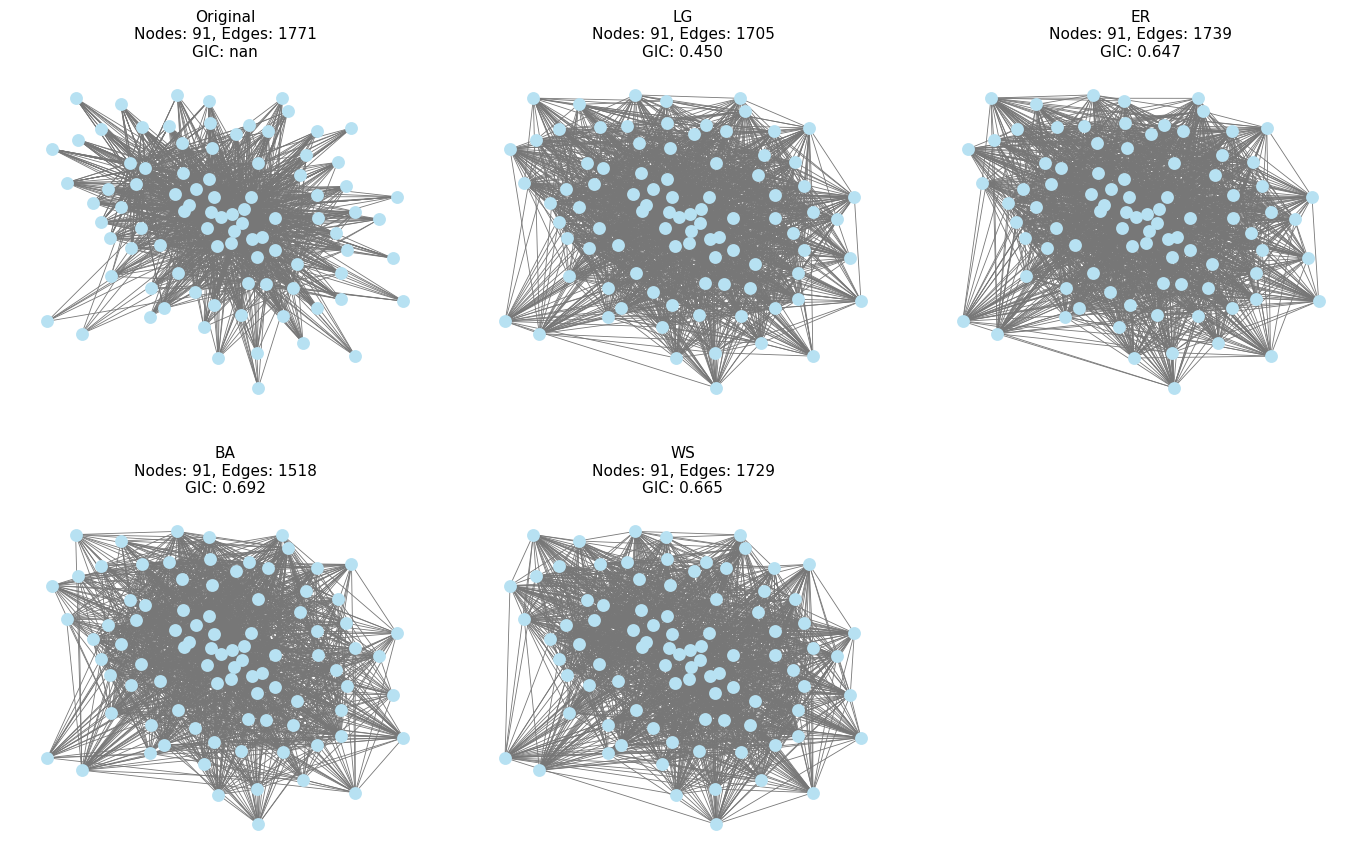

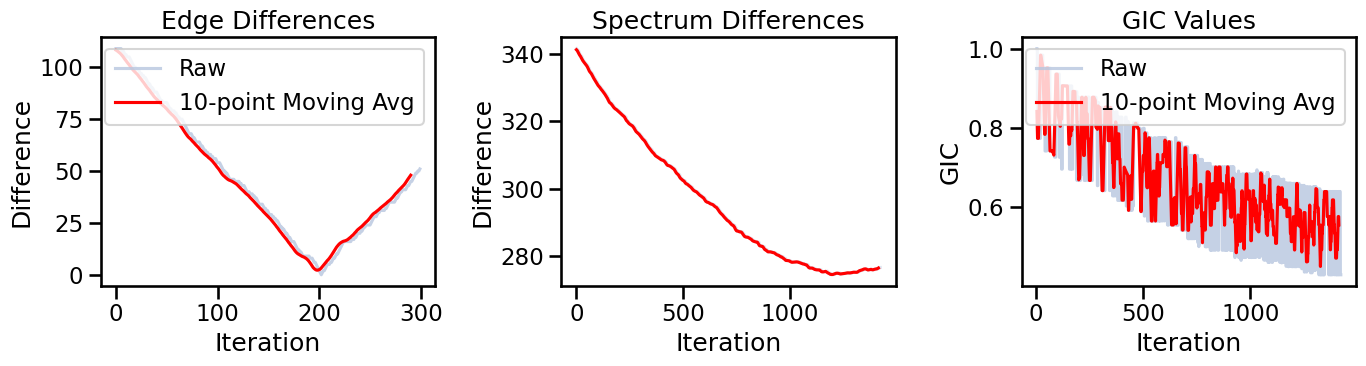

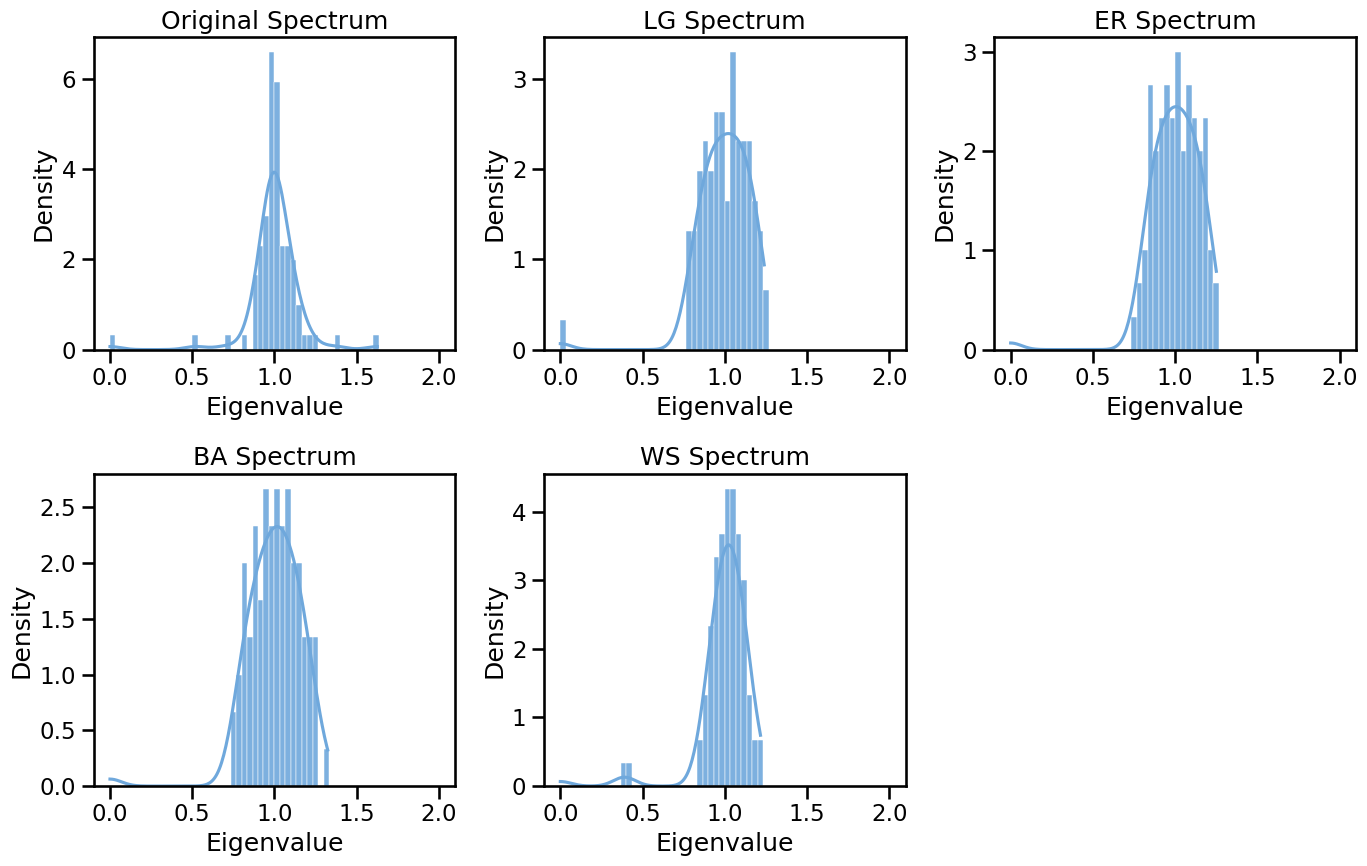

In [144]:
# Use existing lg_fitter, comparators, and gic_results (no recomputation)
import os

assert len(graph_files) >= 1
basename = os.path.basename(graph_files[0])

original_graph = nx.read_graphml(graph_files[0])
original_graph = nx.convert_node_labels_to_integers(original_graph.to_undirected())

models_dict = comparators[basename]               # {'BA': G, 'ER': G, 'WS': G}
gic_base = gic_results[basename]                 # {'BA': ..., 'ER': ..., 'WS': ...}
lg_fitter_obj = lg_fitter                        # provided object

os.makedirs('figs2/animal', exist_ok=True)

# 1) Graphs panel with precomputed GIC labels
plot_graphs_from_fits(original_G=original_graph,
                      lg_fitter_obj=lg_fitter_obj,
                      models_dict=models_dict,
                      gic_results_for_base=gic_base,
                      save_path='figs2/animal/rhesus_graphs.png')

# 2) Convergence panels
plot_convergence_from_lg(lg_fitter_obj, save_path='figs2/animal/rhesus_iteration.png')

# 3) Spectra panel
plot_spectra_from_fits(original_G=original_graph,
                       lg_fitter_obj=lg_fitter_obj,
                       models_dict=models_dict,
                       bins=60,
                       save_path='figs2/animal/rhesus_spectrum.png')

print('Saved: figs2/animal/rhesus_graphs.png')
print('Saved: figs2/animal/rhesus_iteration.png')
print('Saved: figs2/animal/rhesus_spectrum.png')